# Object Detection with Transfer Learning

As seen in the previous part of the project, **Mini-YOLO from scratch** was capable of **localizing** objects, but struggled with classification, often defaulting to the majority class ('Person'). The objective now is to implement a fully functional model that achieves this tasks with great performance.

* To fullfill this goal, transfer learning will be used with **YOLOv8** from [Ultralytics](https://docs.ultralytics.com/es/models/yolov8/#what-is-yolov8-and-how-does-it-differ-from-previous-yolo-versions).
* **Why this version?** - It's an industry standard with more than enough power to handle the dataset used. **Ultralytics** built and mantained the framework making it easy to use,realiable and open source.
* **Transfer Learning and addressing the Class Bias**:
  YOLOv8 was already trained with the [Common Objects in Context Dataset](https://cocodataset.org/#home). It contains 330000 images and 1.5 million objects, and the 20 classes of PASCAL VOC are already present in the COCO one (it contains 80 classes in total). With this pre-trained weights, the model will thrive achieving the final goal.

The pipeline will be the following one:
1. Load frameworks
2. Paths and configuration
3. Train the model
4. Quantitative Evaluation
5. Visualization inference
6. Final conclussions for the whole project
---
Credits to:
* [Ultralytics](https://docs.ultralytics.com/es/models/yolov8/#what-is-yolov8-and-how-does-it-differ-from-previous-yolo-versions) for the YOLOv8 framework and implementation.

## 1. Load Frameworks

For YOLOv8 to work properly in Kaggle/Google collab some pre-installed libraries need to be installed in previous versions, as the current versions are not optimized yet.

In [ ]:
# Uninstall problematic packages 
!pip uninstall -y numpy opencv-python-headless opencv-python ultralytics > /dev/null 2>&1

# Re-install with strict version pinning
# lock NumPy to <2.0 to keep TensorFlow, Colab, and OpenCV happy
!pip install "numpy<2.0" "opencv-python-headless>=4.8" "ultralytics" > /dev/null 2>&1

# Force a Runtime Restart
# kills the current session so the new libraries are loaded fresh
import os
print("Restarting Runtime to apply fixes...")
os.kill(os.getpid(), 9)

In [1]:
import ultralytics
from ultralytics import YOLO
import os
import yaml
import torch
import shutil

print(f"Ultralytics Version: {ultralytics.__version__}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics Version: 8.3.231


## 2. Paths and Configuration

For YOLOv8 to operate, the data needs to be reestructured to a standtard folder structure in the working directory using shortcuts (**Symlinks**). 

In [3]:
# Root Path to the Preprocessed Data
INPUT_PREPROCESS = '/kaggle/input/pascal-voc-eda-and-preprocessing' 
INPUT_IMAGES = '/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/JPEGImages'

# Destination Folders in Working Directory
WORK_DIR = '/kaggle/working/yolo_data'
os.makedirs(os.path.join(WORK_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(WORK_DIR, 'labels'), exist_ok=True)

# Simlink images: Instead of copying, shortcuts are created
for img_name in os.listdir(INPUT_IMAGES):
    if img_name.endswith('.jpg'):
        src = os.path.join(INPUT_IMAGES, img_name)
        dst = os.path.join(WORK_DIR, 'images', img_name)
        if not os.path.exists(dst):
            os.symlink(src, dst)

# Copy labels (text files are small)
LABEL_SRC = os.path.join(INPUT_PREPROCESS, 'labels')
for label_name in os.listdir(LABEL_SRC):
    if label_name.endswith('.txt'):
        shutil.copy(
            os.path.join(LABEL_SRC, label_name),
            os.path.join(WORK_DIR, 'labels', label_name)
        )

# Generate new split files
def create_local_split(split_name):
    old_path = os.path.join(INPUT_PREPROCESS, f'{split_name}.txt')
    new_path = os.path.join(WORK_DIR, f'{split_name}.txt')

    with open(old_path, 'r') as f_in, open(new_path, 'w') as f_out:
        for line in f_in:
            # Extract file name
            filename = os.path.basename(line.strip())
            # Write new local path
            f_out.write(os.path.join(WORK_DIR, 'images', filename) + '\n')

    return new_path

train_path = create_local_split('train')
val_path = create_local_split('val')

# Define the dictionary
data_config = {
    'train': train_path,
    'val': val_path,
    'names' : { # Classes
        0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle',
        5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow',
        10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike',
        14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa',
        18: 'train', 19: 'tvmonitor'
    }
}

config_path = '/kaggle/working/yolov8_pascal.yaml'

with open(config_path, 'w') as f:
    yaml.dump(data_config, f)

## 3. Training

This is where the power of transfer learning is appreciable. The managing of the Dataset, the loading, training loop, loss and backprop is handled with just one command.

* `yolov8n.pt` **(Nano)** is the version used. It is the smallest, fastest version of YOLOv8, making it a fair comparison to the Mini-YOLO from scratch model.

In [4]:
# Load pre-trained weights
model = YOLO('yolov8n.pt')

results = model.train(
    data=config_path,         # Path to the .yaml file
    epochs=20,                # Same epochs as Mini-YOLO
    imgsz=416,                # Image size
    batch=16,                 # Batch size
    project='YOLOv8_PASCAL',  # Folder of results
    name='run_transfer',      # Subfolder name
    optimizer='Adam',         # match optimizer with Mini-YOLO
    lr0=1e-3,                 # Initial learning rate
    plots=True,               # Generate training graphs
)

Ultralytics 8.3.231 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolov8_pascal.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run_transfer, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspecti

## 4. Quantitative Evaluation

Now that the model is trained, it will be evaluated utilizing the **mAP (mean Average Precission)**. It calculates the precission for every single class and averages them together.
* `mAP@50`: check if the predicted box overlaps with the real box by at least 50%.
* `mAP@50-95`: averages the scores across 10 different strictness levels up to 95%.

In [5]:
metrics = model.val()
print(f"mAP@50: {metrics.box.map50:.4f}")
print(f"mAP@50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.231 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 103.0±68.6 MB/s, size: 82.9 KB)
val: Scanning /kaggle/working/yolo_data/labels.cache... 2510 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2510/2510 3.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 157/157 12.6it/s 12.5s0.1s
                   all       2510       6307       0.73      0.604      0.674      0.463
             aeroplane        126        155      0.769      0.665      0.763      0.531
               bicycle        127        177       0.83      0.701      0.791      0.533
                  bird        150        243      0.715      0.477      0.575      0.362
                  boat        100        150      0.721       0.48      0.561      0.346
                bottle  

* The model scored **0.6737** in `mAP@50` - 67.4% of the times correctly finds and classifies objects.
* In `mAP@50-90` it scored **0.4627** - scores above 0.40 are considered excellent for real-time models.
* Total training time was about 17 minutes with Kaggle's GPU P100, which was surprisingly fast.
* Classes like train (0.829), car (0.821), person (0.808) got high scores compared to the lowest ones: pottedplant (0.448) and bottle (0.503). This means that the model thrives in detecting large and distinc objects compared to small ones that have lot of variation in shape. 

## 5. Visualization Inference

Similar to the previous stage with Mini-YOLO, visual validation is implemented in order to check the performance of the model.


image 1/1 /kaggle/working/yolo_data/images/004091.jpg: 320x416 1 car, 8 persons, 34.7ms
Speed: 1.3ms preprocess, 34.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)


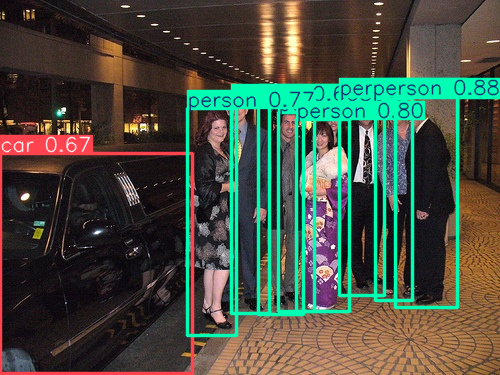

In [6]:
import glob
import random
from IPython.display import display
from PIL import Image as PILImage 

# Get list of validation images
val_images = glob.glob(os.path.join(WORK_DIR, 'images', '*.jpg'))

# Pick a random one
test_image = random.choice(val_images)

# Run prediction
results = model.predict(test_image, conf=0.5)

# Show result
for result in results:
    im_array = result.plot()  # plot a BGR numpy array of predictions
    # Use the renamed class 'PILImage'
    im = PILImage.fromarray(im_array[..., ::-1])  # RGB PIL image
    display(im)

## 6. Final Conclussions for the whole project

Finally, lets wrap up with a little comparison between the models:

| Metric | Mini-YOLO (From Scratch) | YOLOv8 (Transfer Learning) |
| :--- | :--- | :--- |
| **Architecture** | Shallow Custom CNN | Deep CSPDarknet |
| **Training Time** | ~1.15 hours | ~17 minutes|
| **Loss Trend** | High Variance (Overfitting) | Stable Convergence |
| **Detection Quality** | Good Localization, Bad Classification | Perfect Localization & Classification |
| **mAP@50** | N/A (Visual Validation Only) | 67.4% |

This confirms that obviously the transfer-learning approach is far superior to achieve good performances and that the PASCAL VOC suits perfectly the pre-trained weights of YOLOv8.

There's room for improvement as the final model took only 17 minutes to train, and the results were excellent.

**Overall**, this project was really enjoyable. Getting something done from scratch that more or less works with nowadays standards is a huge feat, but the knowledge developed with this approach is so much worth it!

Key things that I got from this project:
* How to deal, analyze and preprocess image-label datasets.
* Intuition into CNN backbones, Residual Blocks and the mechanics of YOLO.
* Leverage of SOTA frameworks(Ultralytics) to deliver industry standard performance.

If you got this far, thank you for your time! Any feedback is appreciated, here are my socials:

* **Github**: [antoniomacu](https://github.com/antoniomacu)
* **Linkedin**: [Antonio Martín Acuña](https://www.linkedin.com/in/antonio-mart%C3%ADn-acu%C3%B1a-328793208/)